In [1]:
# Import used libraries
from imblearn.over_sampling import SMOTE # solving imbalanced dataset
from sklearn.model_selection import train_test_split

import xgboost as xgb # model
from xgboost import XGBClassifier # model

# evaluation metrics
from sklearn import metrics
from sklearn.metrics import fbeta_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

# parametar tuning
from sklearn.model_selection import GridSearchCV

import pandas as pd
from sklearn import preprocessing
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
# XGBoost with specific parameters and cross validation
def modelfit(alg, X, y, cv_folds=4, early_stopping_rounds=5):

    # In the first step we will split the data in training and remaining dataset
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state = 4)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state = 4)
    
    # Fit
    alg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
    
    # Predict
    y_pred = alg.predict(X_test)
    
    # Print model report:
    print("MCC : %.4g" % matthews_corrcoef(y_test, y_pred))
    print("AUC Score: %f" % metrics.roc_auc_score(y_test, y_pred))
    
    return alg, y_pred

In [5]:
# Test Data: Uning only numerical + date

# Merge all features into one dataset
train_numerical = pd.read_pickle("features_v3.pkl") # only numerical
train_date = pd.read_pickle("train_date_features.pkl")
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)

df = train_features
# Replace nulls with mean
df = df.fillna(df.mean())
X = df[0:1000000].drop(columns=['Id', 'Response'])
y = df[0:1000000]['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(len(X), len(y))
test = df[1000000:]
X_test = test.drop(columns=['Id', 'Response'])
y_test = test['Response']

# Fit XGBoost on full train data
model = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1)
alg, y_pred = modelfit(model, X, y)

[0]	validation_0-logloss:0.65498	validation_1-logloss:0.65510
[1]	validation_0-logloss:0.62429	validation_1-logloss:0.62441
[2]	validation_0-logloss:0.59803	validation_1-logloss:0.59827
[3]	validation_0-logloss:0.58205	validation_1-logloss:0.58233
[4]	validation_0-logloss:0.55896	validation_1-logloss:0.55925
[5]	validation_0-logloss:0.53806	validation_1-logloss:0.53837
[6]	validation_0-logloss:0.51631	validation_1-logloss:0.51663
[7]	validation_0-logloss:0.50017	validation_1-logloss:0.50050
[8]	validation_0-logloss:0.48631	validation_1-logloss:0.48665
[9]	validation_0-logloss:0.47281	validation_1-logloss:0.47321
[10]	validation_0-logloss:0.45596	validation_1-logloss:0.45630
[11]	validation_0-logloss:0.43792	validation_1-logloss:0.43821
[12]	validation_0-logloss:0.42276	validation_1-logloss:0.42302
[13]	validation_0-logloss:0.41131	validation_1-logloss:0.41153
[14]	validation_0-logloss:0.39819	validation_1-logloss:0.39839
[15]	validation_0-logloss:0.38877	validation_1-logloss:0.38893
[1

In [6]:
# Test Data 3: Uning only numerical + date + normalized date
# Merge all features into one final dataset

train_numerical = pd.read_pickle("features_v3.pkl") # only numerical
train_date = pd.read_pickle("train_date_features.pkl")
# Standardize date
train_date = train_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    train_date[column] = (train_date[column] - train_date[column].mean()) / train_date[column].std()
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)

# Include all faults
faults = train_features[train_features['Response']==1]
df = train_features.sample(n = 200000)
df = pd.concat([faults,df])
# Replace nulls with mean
df = df.fillna(10)
X = df[0:100000].drop(columns=['Id', 'Response'])
y = df[0:100000]['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X = X.replace(10, np.nan)
print(len(X), len(y))
test = df[100000:150000]
X_test = test.drop(columns=['Id', 'Response'])
X_test = X_test.replace(10, np.nan)
y_test = test['Response']

# Fit XGBoost
model = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=10,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=8, missing=np.nan)
alg, y_pred = modelfit(model, X, y)

[0]	validation_0-logloss:0.64539	validation_1-logloss:0.64577
[1]	validation_0-logloss:0.60596	validation_1-logloss:0.60683
[2]	validation_0-logloss:0.56768	validation_1-logloss:0.56914
[3]	validation_0-logloss:0.53561	validation_1-logloss:0.53776
[4]	validation_0-logloss:0.50884	validation_1-logloss:0.51137
[5]	validation_0-logloss:0.48351	validation_1-logloss:0.48646
[6]	validation_0-logloss:0.46322	validation_1-logloss:0.46642
[7]	validation_0-logloss:0.44307	validation_1-logloss:0.44681
[8]	validation_0-logloss:0.42238	validation_1-logloss:0.42636
[9]	validation_0-logloss:0.40232	validation_1-logloss:0.40654
[10]	validation_0-logloss:0.38937	validation_1-logloss:0.39403
[11]	validation_0-logloss:0.37553	validation_1-logloss:0.38077
[12]	validation_0-logloss:0.35966	validation_1-logloss:0.36535
[13]	validation_0-logloss:0.34768	validation_1-logloss:0.35353
[14]	validation_0-logloss:0.33546	validation_1-logloss:0.34154
[15]	validation_0-logloss:0.32284	validation_1-logloss:0.32918
[1

### Training the model

In [11]:
# Withot including features with 0 importance
# Not merger: above 90%
# Split: 50% not null (49, 485)
# Every 1 not null, 10 null
# 13% null
# 149 numeric columns

train_numerical = pd.read_pickle("features_v10.pkl") # only numerical
train_date = pd.read_pickle("train_date_features.pkl")
# Standardize date
train_date = train_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    train_date[column] = (train_date[column] - train_date[column].mean()) / train_date[column].std()
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)

# Include all faults
df = train_features[0:1000000].sample(n=600000)
faults = train_features[train_features['Response']==1]
df = pd.concat([faults,df])

# Replace nulls with mean
df = df.fillna(10)
X = df.drop(columns=['Id', 'Response'])
y = df['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X = X.replace(10, np.nan)
print(len(X), len(y))

test = train_features[1000000:].sample(n=120000)
X_test = test.drop(columns=['Id', 'Response'])
X_test = X_test.replace(10, np.nan)
y_test = test['Response']
print(len(X_test), len(y_test))

model = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=14,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=8, missing=np.nan, booster='gbtree')
alg, y_pred = modelfit(model, X, y)
# save model to file
#pickle.dump(model, open("model5.pickle.dat", "wb"))

606879 606879
1192914 1192914
120000 120000
[0]	validation_0-logloss:0.63580	validation_1-logloss:0.63623
[1]	validation_0-logloss:0.58663	validation_1-logloss:0.58746
[2]	validation_0-logloss:0.54367	validation_1-logloss:0.54478
[3]	validation_0-logloss:0.50710	validation_1-logloss:0.50854
[4]	validation_0-logloss:0.47206	validation_1-logloss:0.47376
[5]	validation_0-logloss:0.44061	validation_1-logloss:0.44240
[6]	validation_0-logloss:0.41306	validation_1-logloss:0.41504
[7]	validation_0-logloss:0.38873	validation_1-logloss:0.39094
[8]	validation_0-logloss:0.36978	validation_1-logloss:0.37213
[9]	validation_0-logloss:0.35001	validation_1-logloss:0.35243
[10]	validation_0-logloss:0.33063	validation_1-logloss:0.33321
[11]	validation_0-logloss:0.31114	validation_1-logloss:0.31394
[12]	validation_0-logloss:0.29522	validation_1-logloss:0.29818
[13]	validation_0-logloss:0.28141	validation_1-logloss:0.28456
[14]	validation_0-logloss:0.26707	validation_1-logloss:0.27033
[15]	validation_0-log

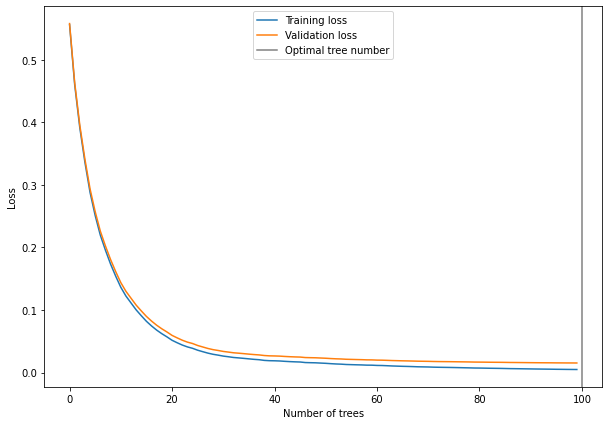

In [11]:
results = alg.evals_result()
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(alg.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [8]:
# PREDICT TRAINING DATA
train_numerical = pd.read_pickle("features_v10.pkl") # only numerical
train_date = pd.read_pickle("train_date_features.pkl")
# Standardize date
train_date = train_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    train_date[column] = (train_date[column] - train_date[column].mean()) / train_date[column].std()
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)
df = train_features
df = df.fillna(np.nan)

# Predict
y_pred = alg.predict(df.drop(columns=['Id', 'Response']))
y_test = df['Response']
# Print model report:
print("MCC : %.4g" % matthews_corrcoef(df['Response'], y_pred))
print("AUC Score: %f" % metrics.roc_auc_score(df['Response'], y_pred))

MCC : 0.595
AUC Score: 0.812176


In [6]:
# PREDICT TESTING DATA

# Merge all features into one dataset
model = alg
test_numerical = pd.read_pickle("test_numerical_features_10.pkl")
test_date = pd.read_pickle("test_date_features.pkl")
# Standardize date
test_date = test_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    test_date[column] = (test_date[column] - test_date[column].mean()) / test_date[column].std()
test_features = pd.merge(test_date, test_numerical)
test_features.columns = test_features.columns.astype(str)
df = test_features
df = df.fillna(np.nan)

X_test = df.drop(columns=['Id'])

y_pred = model.predict(X_test)
print(len(y_pred)) # total 1183748
len(list(filter(lambda i: i == 1, y_pred))) # predicted fault 3.3 %

1183748


39123

In [8]:
# PREDICT TRAINING DATA
df = train_features
df = df.fillna(np.nan)

# Predict
y_pred = alg.predict(df.drop(columns=['Id', 'Response']))
y_test = df['Response']
# Print model report:
print("MCC : %.4g" % matthews_corrcoef(df['Response'], y_pred))
print("AUC Score: %f" % metrics.roc_auc_score(df['Response'], y_pred))

MCC : 0.4036
AUC Score: 0.597003


### With additional date features

In [3]:
# Withot including features with 0 importance
# Not merger: above 90%
# Split: 50% not null (49, 485)
# Every 1 not null, 10 null
# 13% null
# 149 numeric columns

train_numerical = pd.read_pickle("features_v9.pkl") # only numerical
train_date = pd.read_pickle("train_date_extended.pkl")

In [4]:
train_date = train_date[['Id', 'max', 'min', 'time_difference','min_time_station','max_time_station','path_length','part_week_start','part_week_end','day_of_week_start','day_of_week_end','parts_in_same_time','faults_next_1_hour','faults_next_10_hours','faults_next_24_hours','faults_last_1_hour','faults_last_10_hours','faults_last_24_hours']]

In [6]:
# Standardize date
train_date = train_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    train_date[column] = (train_date[column] - train_date[column].mean()) / train_date[column].std()
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)

# Include all faults
df = train_features.sample(n=round(len(train_features)/2))
faults = train_features[train_features['Response']==1]
df = pd.concat([faults,df])

# Replace nulls with mean
df = df.fillna(10)
X = df.drop(columns=['Id', 'Response'])
y = df['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X = X.replace(10, np.nan)
print(len(X), len(y))

model = XGBClassifier(learning_rate=0.2,n_estimators=100,max_depth=16,min_child_weight=3,gamma=1,subsample=0.9,colsample_bytree=0.9,objective='binary:logistic',nthread=8, missing=np.nan, booster='gbtree')
alg, y_pred = modelfit(model, X, y)

598753 598753
1176826 1176826
[0]	validation_0-logloss:0.55604	validation_1-logloss:0.55771
[1]	validation_0-logloss:0.46005	validation_1-logloss:0.46328
[2]	validation_0-logloss:0.39112	validation_1-logloss:0.39521
[3]	validation_0-logloss:0.33587	validation_1-logloss:0.34072
[4]	validation_0-logloss:0.28778	validation_1-logloss:0.29342
[5]	validation_0-logloss:0.25092	validation_1-logloss:0.25709
[6]	validation_0-logloss:0.21962	validation_1-logloss:0.22606
[7]	validation_0-logloss:0.19558	validation_1-logloss:0.20233
[8]	validation_0-logloss:0.17341	validation_1-logloss:0.18065
[9]	validation_0-logloss:0.15409	validation_1-logloss:0.16139
[10]	validation_0-logloss:0.13627	validation_1-logloss:0.14373
[11]	validation_0-logloss:0.12225	validation_1-logloss:0.12982
[12]	validation_0-logloss:0.11115	validation_1-logloss:0.11872
[13]	validation_0-logloss:0.10010	validation_1-logloss:0.10771
[14]	validation_0-logloss:0.09079	validation_1-logloss:0.09847
[15]	validation_0-logloss:0.08187	v

In [7]:
# PREDICT TRAINING DATA
df = train_features
df = df.fillna(np.nan)

# Predict
y_pred = alg.predict(df.drop(columns=['Id', 'Response']))
y_test = df['Response']
# Print model report:
print("MCC : %.4g" % matthews_corrcoef(df['Response'], y_pred))
print("AUC Score: %f" % metrics.roc_auc_score(df['Response'], y_pred))

MCC : 0.8088
AUC Score: 0.906823


In [8]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1176868
         1.0       0.81      0.81      0.81      6879

    accuracy                           1.00   1183747
   macro avg       0.90      0.91      0.90   1183747
weighted avg       1.00      1.00      1.00   1183747



In [10]:
# PREDICT TESTING DATA

# Merge all features into one dataset
model = alg
test_numerical = pd.read_pickle("test_numerical_features_9.pkl")
test_date = pd.read_pickle("test_date_extended.pkl")
test_date = test_date[['Id', 'max', 'min', 'time_difference','min_time_station','max_time_station','path_length','part_week_start','part_week_end','day_of_week_start','day_of_week_end','parts_in_same_time','faults_next_1_hour','faults_next_10_hours','faults_next_24_hours','faults_last_1_hour','faults_last_10_hours','faults_last_24_hours']]
# Standardize date
test_date = test_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    test_date[column] = (test_date[column] - test_date[column].mean()) / test_date[column].std()
test_features = pd.merge(test_date, test_numerical)
test_features.columns = test_features.columns.astype(str)
df = test_features
df = df.fillna(np.nan)

X_test = df.drop(columns=['Id'])

y_pred = alg.predict(X_test)
print(len(y_pred)) # total 1183748
len(list(filter(lambda i: i == 1, y_pred))) # predicted fault 5.07 %

1183748


60028